# Reconocimiento de dígitos con KNN

Veamos como interactuar con las clases implementadas en el módulo de C++ haciendo una experimentación muy simplificada, y a modo de ejemplo, del método KNN para reconocer digitos

## Compilando el módulo desde C++

Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/msorondo/anaconda3/bin/python (found version "3.8.5") 
-- Found PythonLibs: /home/msorondo/anaconda3/lib/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/msorondo/Desktop/Metodos Numericos/metnum-tp2
-- Configuring don

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/home/msorondo/Desktop/Metodos Numericos/metnum-tp2/notebooks
Python 3.8.5


## Explorando los datos

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np 

df_train = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

In [4]:
df_train[:10]

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   
5      0       0       0       0       0       0       0       0       0   
6      7       0       0       0       0       0       0       0       0   
7      3       0       0       0       0       0       0       0       0   
8      5       0       0       0       0       0       0       0       0   
9      3       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   
5       0  ...         0         0         0         0         0         0   
6       0  ...         0         0         0         0         0         0   
7       0  ...         0         0         0         0         0         0   
8       0  ...         0         0         0         0         0         0   
9       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  
5         0         0         0         0  
6         0         0         0         0  
7         0         0         0         0  
8         0         0         0         0  
9         0         0         0         0  

[10 rows x 785 columns]

### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [5]:
df_train = df_train[:5000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [6]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 7


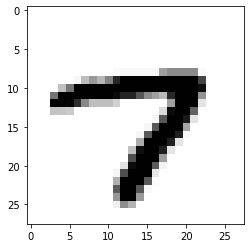

In [7]:
import matplotlib.pyplot as plt

num = 1917

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [8]:
df_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
8    0.0954
4    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [9]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


In [11]:
pca = metnum.PCA(13)
pca.fit(X_train)
X_train = pca.transform(X_train)

X_val = pca.transform(X_val)

clf_metnum = metnum.KNNClassifier(18)
clf_metnum.fit(X_train, y_train)


In [12]:
%%time
from sklearn.metrics import accuracy_score
acc = accuracy_score(clf_metnum.predict(X_val), y_val)
print("Accuracy: {}".format(acc))


NameError: name 'clf_metnum' is not defined

0.914 es el resultado solamente con knn

# Testeo de power iteration con 50 matrices aleatorias simetricas de 28x28 (pasa)

In [10]:
k = 50
def create_k_samples(k):
    #returns a list with k 28x28 random value matrices
    res = []
    for i in range(k):
        np.random.seed(i)
        mat = np.random.rand(28,28)*20 #para que no queden valores muy chicos, preferible que haya overflow
        res.append(mat*mat.T)
    return res
samples = create_k_samples(k)
samples_eigens_np = []
samples_eigens_us = []
for i in range(k):
    samples_eigens_np.append(np.linalg.eigvals(samples[i]).max()) # lista de arrays de autovalores de la matriz i
    samples_eigens_us.append(metnum.power_iteration(samples[i], 5000)[0]) #
print("Esto es para ver que las matrices generadas son distintas(tiene que dar false): ", np.allclose(samples[1],samples[2]))  
print(np.allclose(samples_eigens_us,samples_eigens_np))

Esto es para ver que las matrices generadas son distintas(tiene que dar false):  False
True


In [26]:
for i in range(k):
    eigen_mat_us = np.sort(metnum.get_first_eigenvalues(samples[i], 28, 5000)[0])#  devuelve una tupla de arreglos donde la primera componente de la tupla son los autovalores y la segunda son los autovectores
    eigen_mat_np = np.sort(np.linalg.eigvals(samples[i]))
    print(np.allclose(eigen_mat_us, eigen_mat_np))


True
True
True
True
True
True
False
True
False
True


In [ ]:
eigen_mat

In [ ]:
samples_eigens_us